# Pulsar Classification Project Proposal
###### By Bernie Leung, Phillip Li, Glen Ren, and Helena Tremblay

### Introduction (Phillip)

### Methods & Results (Bernie & Glen)
#### Load Data from Original Source on Web

In [9]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)

# in order to underfit our data, we load a new library with the tools to do so, called caret
library(caret)

set.seed(2022)

pulsar_data <- read_csv("https://raw.githubusercontent.com/glenren/dsci_100_group_24/main/HTRU_2.csv", 
                        col_names = c("mean_int_prof", 
                                      "sd_int_prof",
                                      "kurt_int_prof",
                                      "skew_int_prof",
                                      "mean_curve",
                                      "sd_curve",
                                      "kurt_curve",
                                      "skew_curve",
                                      "class") ) %>%
                        mutate(class = as_factor(class))
head(pulsar_data)

Parsed with column specification:
cols(
  mean_int_prof = col_double(),
  sd_int_prof = col_double(),
  kurt_int_prof = col_double(),
  skew_int_prof = col_double(),
  mean_curve = col_double(),
  sd_curve = col_double(),
  kurt_curve = col_double(),
  skew_curve = col_double(),
  class = col_double()
)



mean_int_prof,sd_int_prof,kurt_int_prof,skew_int_prof,mean_curve,sd_curve,kurt_curve,skew_curve,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


#### Wrangling and Cleaning Data

In [10]:
set.seed(2022) 

# in order to address the skew in our data, we will use an overfitted or underfitted data set to perform our data analysis
# we will perform exploratory data analyses on overfitted and underfitted data sets in order to determine which one has the highest accuracy

pulsar <- which(pulsar_data$class=="1") # making a list of all the entries with Class = 1 (a.k.a. true pulsars)
false <- which(pulsar_data$class=="0")# making a list of all the entries with Class = 0 (a.k.a. false pulsar candidates)
length(pulsar)
length(false)
# here we can see how many observations of each category we have

[1] 1639

[1] 16259

As we have 1,639 true pulsars, and 16,259 false candidates, we can see that our two classes are heavily imbalanced. We can solve this by refitting our data, either by 1. underfitting, which is to reduce the majority class to the size of the minority class, or 2. overfitting, which is to increased the minority class to the size of the majority class. Of course, there are drawbacks to both methods: underfitting leads to loss of information from the minority class, and the duplication of the minority class in overfitting can lead to our classifier seeming more accurate than it really is.

For our dataset, since we have a majority class of 16,259 observations, we chose to go with underfitting since overfitting would require having to run code on 32,518 observations which would take a long time (we attempted this but it timed out in the knn tuning stage). An underfitted dataset would only have 3,278 observations—a lot faster.

In [11]:
# create an underfitted data set
down <- c(sample(false,length(pulsar)),pulsar)
# here we are making a new vector combining the true pulsars and a new random sample of false candidates that has the same length as true pulsars
length(down) # the total amount of observations we have in the "down" vector, we can see
pulsar_down <- pulsar_data[down,] # create new pulsar_data dataframe including the indices in "down" (our underfitted data set)
summary(pulsar_down) # we can see a summary of our new underfitted data set
# looking at the class variable, we see we have an even amount of class = 0 and class = 1 (1639 of each!)

[1] 3278

 mean_int_prof      sd_int_prof    kurt_int_prof     skew_int_prof     
 Min.   :  5.812   Min.   :24.77   Min.   :-1.8760   Min.   :-1.59365  
 1st Qu.: 54.268   1st Qu.:36.58   1st Qu.: 0.1814   1st Qu.: 0.06486  
 Median : 95.512   Median :43.69   Median : 0.6357   Median : 1.24321  
 Mean   : 86.459   Mean   :43.12   Mean   : 1.6690   Mean   : 7.95201  
 3rd Qu.:117.441   3rd Qu.:49.21   3rd Qu.: 2.9610   3rd Qu.:11.60289  
 Max.   :192.617   Max.   :83.80   Max.   : 8.0695   Max.   :68.10162  
   mean_curve          sd_curve        kurt_curve       skew_curve      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.449   Min.   :  -1.938  
 1st Qu.:  2.4971   1st Qu.: 17.09   1st Qu.: 1.654   1st Qu.:   1.701  
 Median :  6.8428   Median : 32.56   Median : 5.235   Median :  28.206  
 Mean   : 29.3071   Mean   : 39.86   Mean   : 5.864   Mean   :  67.867  
 3rd Qu.: 39.5928   3rd Qu.: 62.06   3rd Qu.: 9.029   3rd Qu.:  97.495  
 Max.   :207.3027   Max.   :109.66   Max.   :34.540   Max.

In [12]:
set.seed(2022)

# initial split for underfitted data
# question: should we add split for unfitted data for comparison?

pulsar_down_split <- initial_split(pulsar_down, prop = 0.75, strata = class)  
pulsar_down_train <- training(pulsar_down_split)   
pulsar_down_test <- testing(pulsar_down_split)

#### Summary and visualization of the data set that is relevant for exploratory data analysis related to the planned analysis

After the data is loaded, tidied and downsampled, we conduct an exploratory data analysis to help us decide which predictors to use for our main analysis. Our method of choice is to create a summary data set by taking the mean value of each variable for both classes, and finding the differences in each variable between the two classes.


In [13]:
# summary data set
pulsar_averages <- pulsar_down_train %>%
    group_by(class) %>%
    summarize(across(mean_int_prof:skew_curve, mean))

pulsar_averages

`summarise()` ungrouping output (override with `.groups` argument)



class,mean_int_prof,sd_int_prof,kurt_int_prof,skew_int_prof,mean_curve,sd_curve,kurt_curve,skew_curve
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,116.31308,47.42101,0.2054249,0.3600383,8.84906,23.53961,8.918186,116.71410
1,56.29734,38.65879,3.1443152,15.6402919,49.71400,56.24531,2.747476,17.35808


In creating our summary data set we grouped the data points by class and and applied the mean function to each of the variable columns for both classes using the across function. We then use a bar graph to represent the results found. However, because the summary table generated is not untidy (variables are each in a separate column instead of organized into a single column), we first have to create a dataframe that contains a tidied version of the summary table before passing that dataframe to the ggplot function.

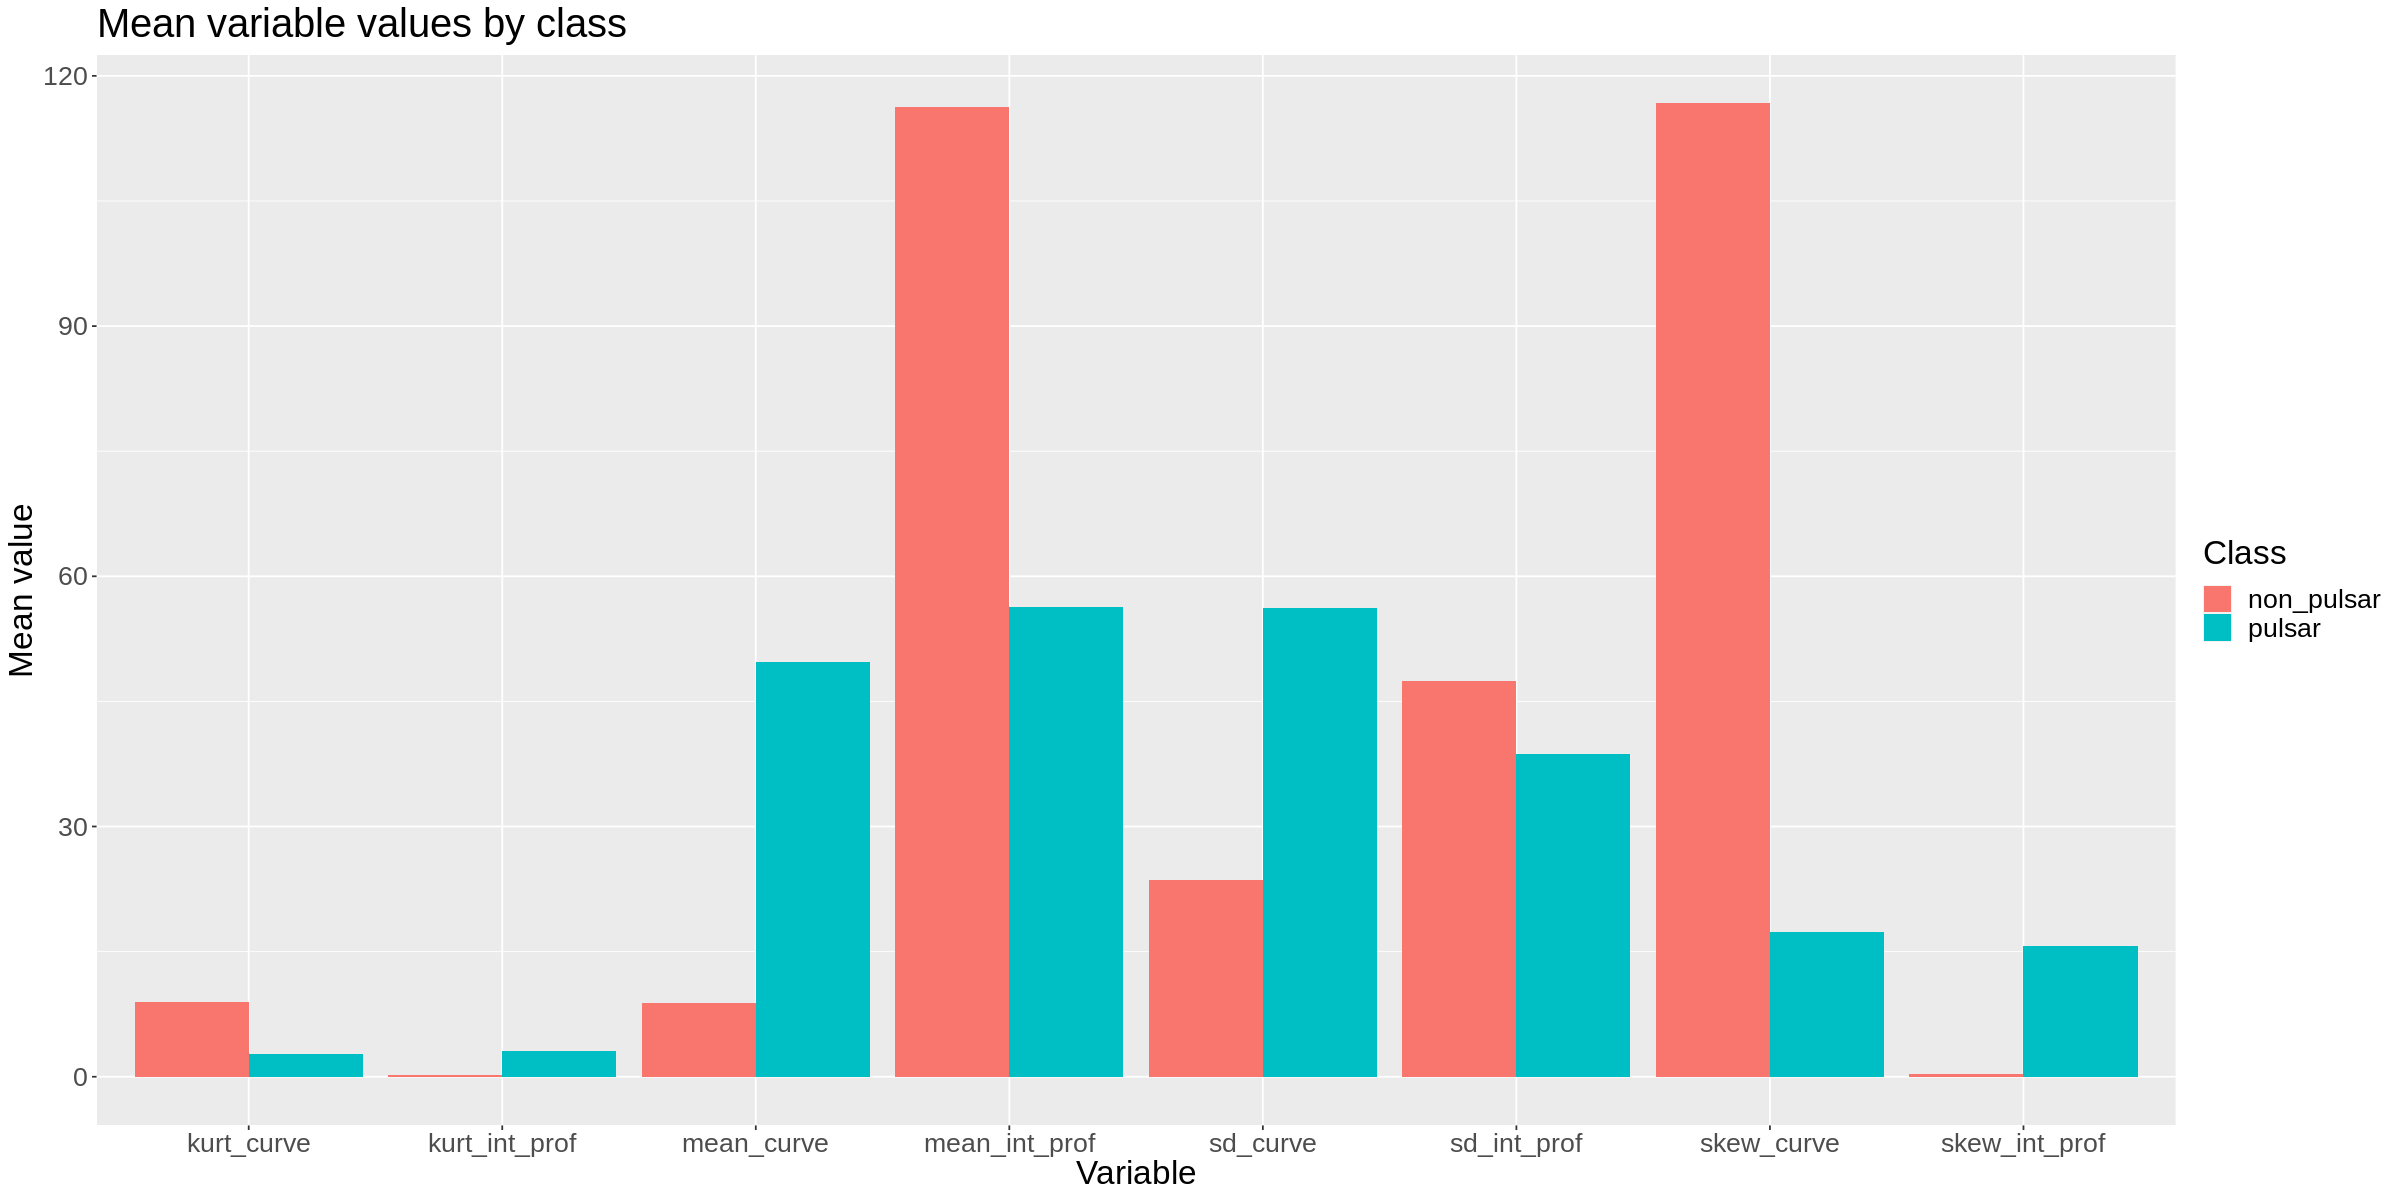

In [24]:
options(repr.plot.width = 20, repr.plot.height = 10) 

tidy_pulsar_averages <- pulsar_averages %>%
    pivot_longer(cols = mean_int_prof:skew_curve, # places all variables in a single column
                names_to = "variable",
                values_to = "mean_value")

averages_viz <- tidy_pulsar_averages %>%
    ggplot(aes(x = variable, y = mean_value, fill = class)) +
    geom_bar(stat = "Identity", position = "dodge") +
    labs(x = "Variable", y = "Mean value", fill = "Class") +
    theme(text = element_text(size=20)) +
    scale_fill_discrete(name = "Class", labels = c("non_pulsar", "pulsar")) +
    ggtitle("Mean variable values by class")

averages_viz

Next, we'll take a look at the relative differences in value between the two classes for each variable to find out which variables vary the most between classess. To do this, we take our orginial pulsar_averages summary table (the untidy version) and find the percentage differences between the two rows. Like the averages table, the differences table is visualized by a bar graph, with the data first being tided...

In [32]:
pulsar_differences <- slice(pulsar_averages, 2) - slice(pulsar_averages, 1) #raw difference in values

pulsar_percentage_difference <- abs(pulsar_differences/slice(pulsar_averages, 1)*100) #percentage difference - 
                                                                                      #absolute value taken for easier comparison
pulsar_percentage_difference

Warning message in Ops.factor(left, right):
“‘-’ not meaningful for factors”
Warning message in Ops.factor(left, right):
“‘/’ not meaningful for factors”


class,mean_int_prof,sd_int_prof,kurt_int_prof,skew_int_prof,mean_curve,sd_curve,kurt_curve,skew_curve
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,51.59844,18.47752,1430.64,4244.064,461.7998,138.939,69.19244,85.12769


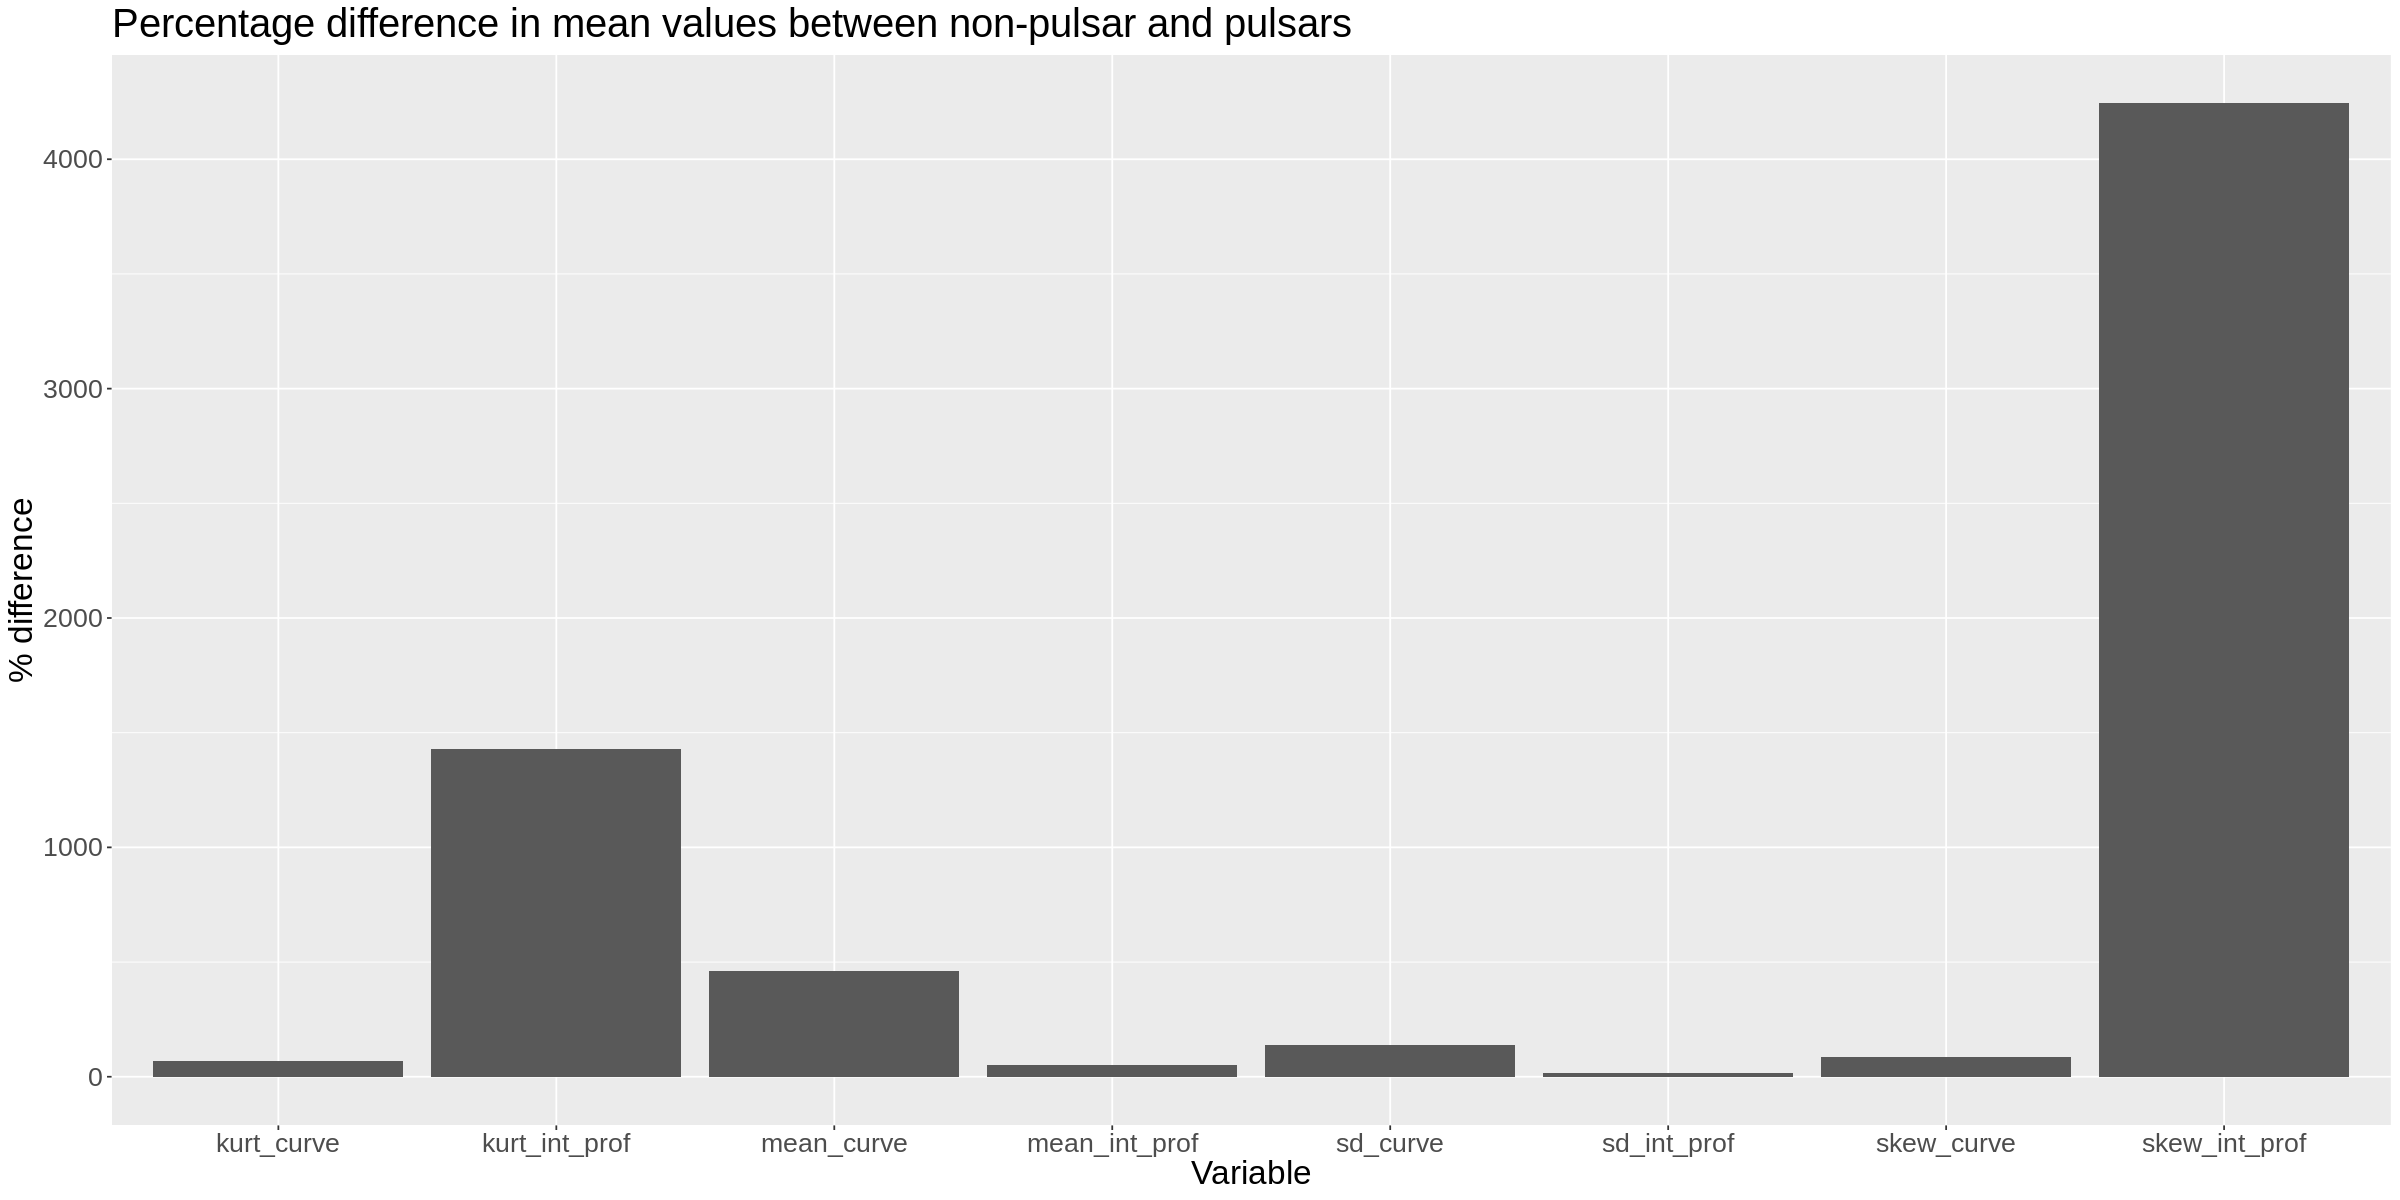

In [31]:
tidy_percentage_diff <- pulsar_percentage_difference %>%
    pivot_longer(cols = mean_int_prof:skew_curve,
                names_to = "variable",
                values_to = "pct_diff")

percentage_diff_viz <- tidy_percentage_diff %>%
    ggplot(aes(x = variable, y = pct_diff)) +
    geom_bar(stat = "Identity")+
    labs(x = "Variable", y = "% difference")+
    theme(text = element_text(size=20)) +
    ggtitle("Percentage difference in mean values between non-pulsar and pulsars")
    
percentage_diff_viz

The three variables with highest values (kurt_int_prof, mean_curve and skew_int_prof) from the percentage difference graph will then be used as our predictors for our data analysis. 

In [7]:
set.seed(2022)

# build recipe for underfitted data
pulsar_down_recipe <- recipe(class ~ mean_int_prof + mean_curve + skew_curve,
                       data = pulsar_down_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
pulsar_down_recipe

# create cross-validation for overfitted and underfitted data
pulsar_down_vfold <- vfold_cv(pulsar_down_train, v = 5, strata = class)

# build model 
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification') 

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [8]:
set.seed(2022)
# underfitted data set results

knn_down_results <- workflow() %>%
    add_recipe(pulsar_down_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = pulsar_down_vfold, grid = 10) %>%
    collect_metrics

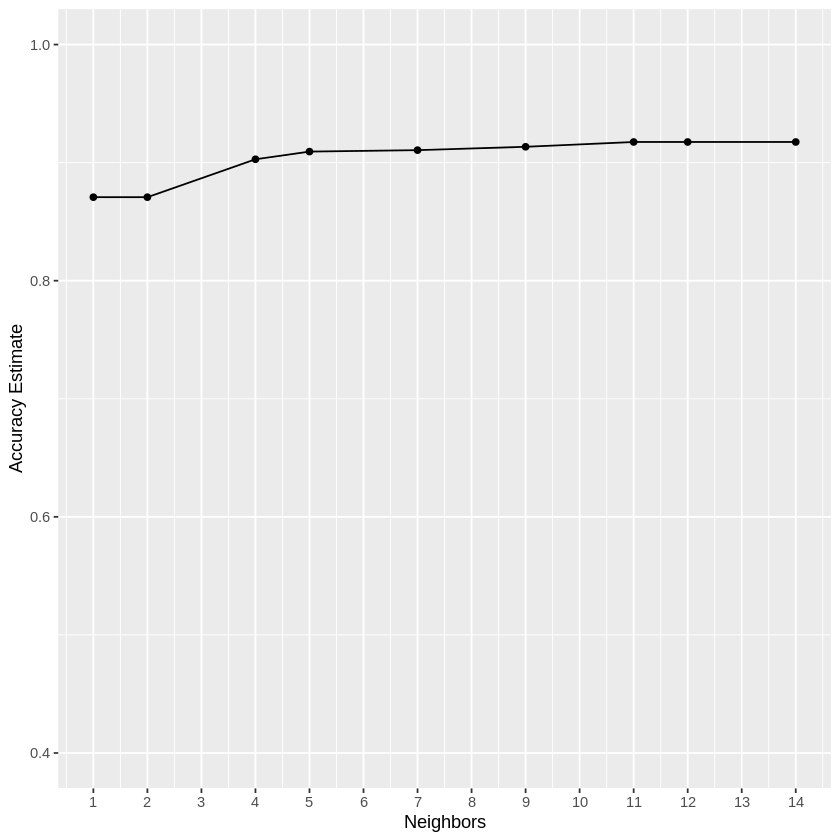

In [9]:
# evaluating classification model with underfitted data sets

accuracies_down <- knn_down_results %>%
    filter(.metric == "accuracy")
cross_val_plot_down <- ggplot(accuracies_down, aes(x= neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
cross_val_plot_down

In [10]:
set.seed(2022)
# used underfitted data set because overfitted data set timed out

knn_spec_down <- nearest_neighbor(weight_func = 'rectangular', neighbors = 12) %>%
    set_engine('kknn') %>%
    set_mode('classification')

pulsar_down_workflow <- workflow() %>%
    add_recipe(pulsar_down_recipe) %>%
    add_model(knn_spec_down)
pulsar_down_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 12
  weight_func = rectangular

Computational engine: kknn 


In [11]:
set.seed(2022)

# fitting data to workflow
pulsar_down_fit <- pulsar_down_workflow %>%
    fit(data = pulsar_down_train)

pulsar_down_summary <- pulsar_down_fit %>%
    predict(pulsar_down_test) %>%
    bind_cols(pulsar_down_test) %>%
    metrics(truth = class, estimate = .pred_class)
pulsar_down_summary

#check majority class to compare
pulsar_down_proportions <- pulsar_down_train %>%
                      group_by(class) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(pulsar_down_train))
pulsar_down_proportions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9107579
kap,binary,0.8215159


`summarise()` ungrouping output (override with `.groups` argument)



class,n,percent
<fct>,<int>,<dbl>
0,1230,50
1,1230,50


#### Summary of the data set that is relevant for exploratory data analysis related to the planned analysis

#### Visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

## Perform the data analysis

## Visualization of the analysis 

### Discussion (Helena)